# Extract Dataset (Only for Google Colab)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
# .ZIP PATH LOCATION
# Format  : /content/gdrive/MyDrive/**.ZIP PATH LOCATION**
# Example : /content/gdrive/MyDrive/militaryaircraftdetectiondataset.zip

# EXTRACT LOCATION
# Format  : /content/**EXTRACT LOCATION**
# Example : /content/militaryaircraftdetectiondataset/

# Kevin
!unzip "/content/gdrive/MyDrive/militaryaircraftdetectiondataset.zip" -d "/content/militaryaircraftdetectiondataset/"

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, applications
from tensorflow.keras.utils import image_dataset_from_directory

# Prepare Dataset

## Load Dataset from Directory

In [2]:
# Colab directory: "militaryaircraftdetectiondataset/crop/"
# VSCode directory: "D:/NTHU/5. Fall 2022/Intro to Intelligent Computing/Final Project/Data/militaryaircraftdetectiondataset/crop/"

dir = "D:/NTHU/5. Fall 2022/Intro to Intelligent Computing/Final Project/Data/militaryaircraftdetectiondataset/crop/"
data_path = pathlib.Path(dir)

SEED = 555
img_size = (128, 128)

train_data = image_dataset_from_directory(directory=data_path,
                                          image_size=img_size,
                                          batch_size=40,
                                          shuffle=True,
                                          seed=SEED,
                                          validation_split=0.3,
                                          subset="training")

val_data = image_dataset_from_directory(directory=data_path,
                                        image_size=img_size,
                                        batch_size=40,
                                        shuffle=True,
                                        seed=SEED,
                                        validation_split=0.3,
                                        subset="validation")

Found 13869 files belonging to 40 classes.
Using 9709 files for training.
Found 13869 files belonging to 40 classes.
Using 4160 files for validation.


## Visualize Data

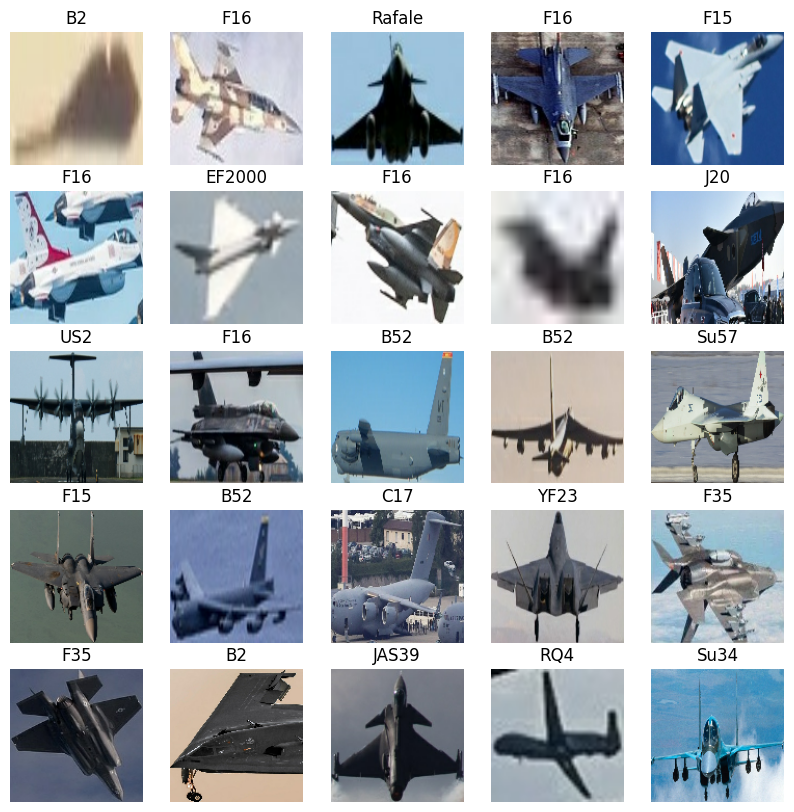

In [3]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Prefetch Data

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
prefetch_train = train_data.prefetch(buffer_size=AUTOTUNE)
prefetch_val = val_data.prefetch(buffer_size=AUTOTUNE)

# Model

For the model, we use ResNet50 as our base model, and implemented transfer learning into it in order to increase our model's performance.

## Part 1: Feature Extraction

### Create Base Model

In [5]:
img_shape = img_size + (3,)

# Input Preprocessing
preprocess_input = applications.resnet50.preprocess_input

# Base Model: ResNet50
base_model = applications.ResNet50(input_shape=img_shape, include_top=False, weights="imagenet")

# Freeze layers
base_model.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

### Data Augmentation

In [6]:
data_augmentation = tf.keras.Sequential()
#data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomRotation(0.01))
data_augmentation.add(layers.RandomRotation(0.01))
data_augmentation.add(layers.RandomZoom(0.01))
data_augmentation.add(layers.RandomContrast(0.01))
data_augmentation.add(layers.RandomBrightness(0.01))

### Add Extra Layers

In [7]:
n_class = len(class_names)

global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(n_class, activation="softmax")

inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

### Compile Model

In [8]:
optimizer = optimizers.Adam(learning_rate=optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

### Train Model

In [9]:
n_epochs = 4

history = model.fit(prefetch_train, validation_data=(prefetch_val), epochs=n_epochs)

Epoch 1/4
243/243 [==============================] - 207s 816ms/step - loss: 2.8028 - accuracy: 0.2918 - val_loss: 2.2758 - val_accuracy: 0.4034
Epoch 2/4
243/243 [==============================] - 196s 805ms/step - loss: 1.6411 - accuracy: 0.5435 - val_loss: 2.0522 - val_accuracy: 0.4471
Epoch 3/4
243/243 [==============================] - 198s 815ms/step - loss: 1.4758 - accuracy: 0.5936 - val_loss: 2.0523 - val_accuracy: 0.4469
Epoch 4/4
243/243 [==============================] - 197s 809ms/step - loss: 1.4806 - accuracy: 0.5921 - val_loss: 2.0523 - val_accuracy: 0.4469


### Model Performance

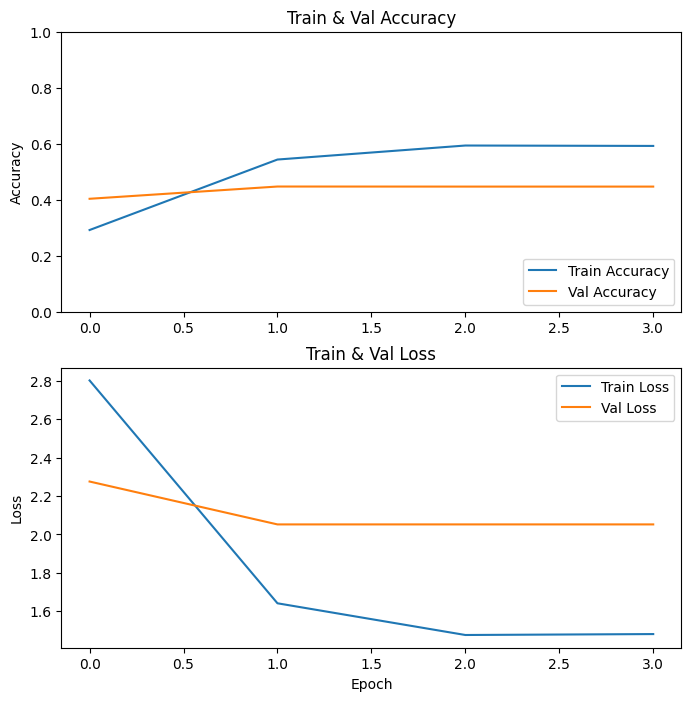

In [10]:
plt.figure(figsize=(8, 8))

# Plot Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Train & Val Accuracy")
plt.ylabel("Accuracy")
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Train & Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

## Part 2: Fine-Tuning

### Unfreeze layers

In [11]:
# Unfreeze layers
base_model.trainable = True

# Fine-tune starting from this layer
start = 100
for layer in base_model.layers[:start]:
    layer.trainable = False

### Recompile Model

In [12]:
optimizer = optimizers.RMSprop(learning_rate=optimizers.schedules.CosineDecay(0.001, 500))
#optimizer = optimizers.Adam(learning_rate=optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

### Continue Training

In [13]:
fine_tune_epochs = 2
fine_tune_n_epochs = n_epochs + fine_tune_epochs

starting_epoch = history.epoch[-1] + 1
fine_tune_history = model.fit(prefetch_train, validation_data=(prefetch_val), epochs=fine_tune_n_epochs, initial_epoch=starting_epoch)

Epoch 5/6
243/243 [==============================] - 418s 2s/step - loss: 1.8538 - accuracy: 0.5108 - val_loss: 1.6099 - val_accuracy: 0.5901
Epoch 6/6
243/243 [==============================] - 408s 2s/step - loss: 0.3354 - accuracy: 0.9117 - val_loss: 0.7273 - val_accuracy: 0.7913


### Model Performance

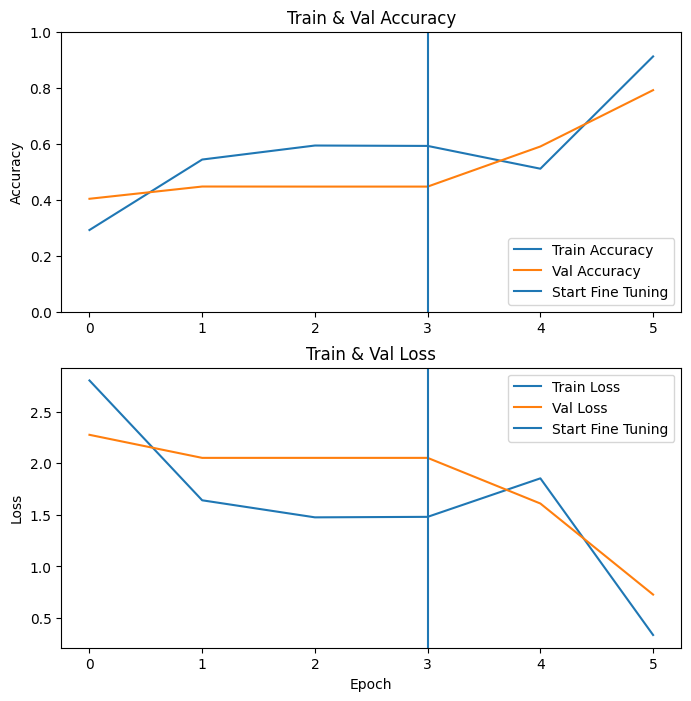

In [16]:
plt.figure(figsize=(8, 8))

# Plot Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history["accuracy"]+fine_tune_history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"]+fine_tune_history.history["val_accuracy"], label="Val Accuracy")
#plt.plot([n_epochs-1, n_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.axvline(x=n_epochs-1, label="Start Fine Tuning")
plt.title("Train & Val Accuracy")
plt.ylabel("Accuracy")
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(history.history["loss"]+fine_tune_history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"]+fine_tune_history.history["val_loss"], label="Val Loss")
#plt.plot([n_epochs-1, n_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.axvline(x=n_epochs-1, label="Start Fine Tuning")
plt.title("Train & Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

## Save Model

In [17]:
model.save("Group17_Classifier_Model.h5")